In [1]:
# 표준 라이브러리
import os
import requests
from IPython.display import Image, display
# 서드파티 라이브러리
import streamlit as st
import openai
from dotenv import load_dotenv
import json
from typing import List, Annotated, Literal, Dict, Callable, TypeVar, Tuple, Type, Generic, Optional, Union, Any
from typing_extensions import TypedDict  # TypedDict를 typing_extensions에서 import



# LangChain 및 LangGraph 관련 라이브러리
from langchain_openai import OpenAI
from langchain_groq import ChatGroq
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains import LLMChain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.language_models.chat_models import BaseChatModel
from langchain.agents import AgentExecutor
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper
from langchain.tools import tool

from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langsmith import utils 
from agents.agent_library import agent_configs, AgentConfig
from datetime import datetime, timedelta
from dateutil.parser import parse
import yfinance as yf
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate

from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command
from sec_tool.sec_insider_trade_field_definitions import SEC_Insider_Trade_NecessaryFields
from sec_tool.sec_financial_fiedls_definitions import FinancialNecessaryFields
from sec_tool.insider_trade_tool import SECInsiderTradeAPI
from sec_tool.market_data_tool import MarketDataTools, FinancialDataTools


In [2]:
# 환경 변수 로드
load_dotenv()
print(utils.tracing_is_enabled())

MODEL_NAME = "gemma2-9b-it"

True


In [3]:
SEC_API_KEY = os.getenv("SEC_API_KEY")

small_llm = ChatGroq(
    model=MODEL_NAME,
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

In [4]:

# 시장 조사 에이전트
market_research_agent = create_react_agent(
    llm, 
    tools=MarketDataTools.get_polygon_tools(), 
    state_modifier='You are a market researcher. Provide fact only not opinions'
)

def market_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    시장 조사 node. 주어진 state를 기반으로 시장 조사 에이전트를 호출하고,
    결과를 supervisor node로 전달

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = market_research_agent.invoke(state)
    
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_research')]},
        goto='supervisor'
    )



In [5]:
stock_research_tools = [MarketDataTools.get_stock_price]
stock_research_agent = create_react_agent(
    llm, tools=stock_research_tools, state_modifier='You are a stock researcher. Provide facts only not opinions'
)


def stock_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    주식 조사 node
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = stock_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='stock_research')]},
        goto='supervisor'
    )




In [6]:

company_research_tools = [FinancialDataTools.company_research_tool]
company_research_agent = create_react_agent(
    llm, tools=company_research_tools, state_modifier='You are a company researcher. Provide facts only not opinions'
)

def company_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    회사 조사 node

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = company_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='company_research')]},
        goto='supervisor'
    )



In [7]:
analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide wheter to buy, sell, or hold the stock.

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst_node(state: MessagesState):
    """
    분석가 node

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환
    """
    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [result]}

In [ ]:

current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

insider_tracker_system_prompt = f"""You are an insider trading analyst.
You must provide factual data only, without any personal opinions or speculations.
The current time is {current_time}. Use this time when invoking tools that require the current time as an argument."""

insider_tracker_research_prompt = ChatPromptTemplate.from_messages([
    ("system", insider_tracker_system_prompt),
    ("human", "{messages}")
])

insider_tracker_research_tools = [SECInsiderTradeAPI.fetch_filings]
insider_tracker_research_agent = create_react_agent(
    llm, tools=insider_tracker_research_tools, prompt=insider_tracker_research_prompt
)



def insider_tracker_research_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    내부자 거래 내역 조사 node 
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = insider_tracker_research_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='insider_tracker_research')]},
        goto='supervisor'
    )



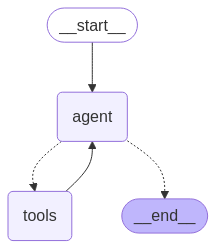

In [11]:
insider_tracker_research_agent

In [13]:
members = ["market_research", "stock_research", "company_research","insider_tracker_research"]
options = members + ["FINISH"]


system_prompt = (
    "You are a supervisor tasked with managing a conversation between the following workers: "
    f"{members}. Given the following user request, respond with the worker to act next. "
    "Today's date is {current_date}. Workers must use this date explicitly. "
    "Each worker will perform a task and respond with their results and status. "
    "When finished, respond with FINISH."
).format(current_date=datetime.now().strftime("%Y-%m-%d"))


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]



def supervisor_node(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 analyst node로 이동

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령 반환 
    """
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [14]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("market_research", market_research_node)
graph_builder.add_node("stock_research", stock_research_node)
graph_builder.add_node("company_research", company_research_node)
graph_builder.add_node("insider_tracker_research", insider_tracker_research_node)
graph_builder.add_node("analyst", analyst_node)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)
graph = graph_builder.compile()



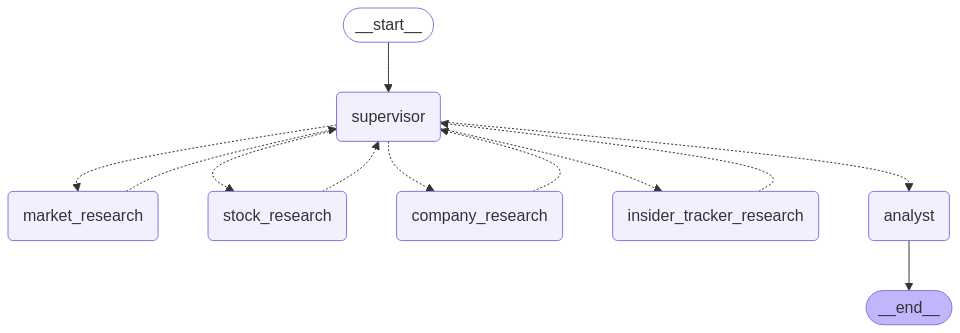

In [15]:
graph

In [16]:
for chunk in graph.stream(
    {"messages": [("user", "최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘
200
================================ Human Message =================================
Name: insider_tracker_research

최근 한 달간 테슬라(TSLA)의 내부자 거래 내역은 다음과 같습니다:

1. **제임스 R 머독 (James R. Murdoch)** - 이사
   - **거래일:** 2025-03-10
     - **매수:** 180,000 주 (주당 23.85 USD)
     - **매수:** 351,787 주 (주당 24.73 USD)
     - **매도:** 54,776 주 (주당 240.788 USD)

2. **바이바프 타네자 (Vaibhav Taneja)** - 최고재무책임자 (CFO)
   - **거래일:** 2025-03-05
     - **매수:** 6,538 주 (가격 미제공)
   - **거래일:** 2025-03-06
     - **매도:** 2,672.25 주 (주당 268.729 USD)

3. **바이바프 타네자 (Vaibhav Taneja)** - 최고재무책임자 (CFO)
   - **거래일:** 2025-03-03
     - **매수:** 6,000 주 (주당 18.22 USD)
     - **매도:** 여러 거래로 여러 주 매도 (가격 범위: 280.920 USD - 303.840 USD)

4. **로빈 M 덴홀름 (Robyn M. Denholm)** - 이사
   - **거래일:** 2025-03-03
     - **매수:** 112,390 주 (주당 24.73 USD)
     - **매도:** 여러 거래로 여러 주 매도 (가격 범위: 292.310 USD - 303.588 USD)

이 정보는 테슬라의 공식 내부자 거래

In [ ]:
for chunk in graph.stream(
    {"messages": [("user", "24년 1월에 테슬라를 매도한 내부자가 있나?")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()